---

## 🧬 Project Overview

CT heart segmentation plays a vital role in medical image analysis, enabling precise visualization and diagnosis of cardiac conditions. It assists clinicians in assessing and treating:

Coronary Artery Disease

Cardiomegaly (enlarged heart)

Congenital Heart Defects

In this project, we develop a deep learning solution leveraging the U-Net architecture, which is highly effective for biomedical segmentation tasks. Our goal is to achieve accurate and reliable segmentation of the heart from CT scan images, aiding in advanced clinical decision-making.

---

# <center><span style="color:#894572"><strong>❤️ CT Heart Segmentation using U-Net 🧠📊</strong></span></center>

---


### Tabel of Contents:

* [Introduction](#0)
* [Import Libraries](#1)
* [Loading Data](#2)
* [EDA](#3)
* [Modeling](#5)
* [Evaluation](#6)
* [Pretrained UNet](#7)
* [Evaluation](#8)

**<a id="0"></a>
<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #5642C5; box-shadow: 10px 10px 10px #042b4c">Introduction</p></b></h1>
<a class="btn" href="#home">Tabel of Contents</a>

### 🧠 What is U-Net?

**U-Net** is a convolutional neural network architecture specifically designed for biomedical image segmentation. It was introduced in 2015 by Olaf Ronneberger et al. and has since become a standard in medical image analysis due to its ability to produce precise segmentations even with limited training data.

The U-Net architecture is characterized by a **U-shaped structure**, consisting of:

- **Contracting Path (Encoder):** Captures context through successive convolution and max-pooling layers.
- **Expanding Path (Decoder):** Enables precise localization using upsampling and skip connections.
- **Skip Connections:** Connect corresponding layers in the encoder and decoder to retain spatial information lost during downsampling.

This architecture allows U-Net to learn both **global features** and **fine-grained local details**, making it highly effective for tasks like retinal blood vessel segmentation where accurate boundary detection is crucial.

---
<div style="text-align: center;">
  <img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" alt="U-Net Architecture" width="700">
</div>


**<a id="1"></a>
<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #5642C5; box-shadow: 10px 10px 10px #042b4c">Import Libraries</p></b></h1>
<a class="btn" href="#home">Tabel of Contents</a>

In [1]:
pip install segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Common
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import os
import math
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Data
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm 

# Model
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
import keras 
from keras.models import Model
from keras.layers import Input,Conv2D,MaxPool2D,Conv2DTranspose,Resizing,Concatenate,Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint
import albumentations as A
from albumentations.core.composition import OneOf
import segmentation_models as sm

# Metrics 
from tensorflow.keras.metrics import *

# Ignore
import warnings
warnings.filterwarnings("ignore")

2025-07-04 18:13:12.461255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751652792.658839      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751652792.715011      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Segmentation Models: using `tf.keras` framework.


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


**<a id="2"></a>
<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #5642C5; box-shadow: 10px 10px 10px #042b4c">Loading Data</p></b></h1>
<a class="btn" href="#home">Tabel of Contents</a>

In [3]:
##### 
image_size = 256

# ✅ Augmentation using Albumentations
augmentation = A.Compose([
    A.HorizontalFlip(p=.5),
    A.VerticalFlip(p=.5),
    A.Rotate(limit=.45, p=1.0)
])

# ✅ Function to load image or mask from path
def load_image(path, size, mask=False):
    image = cv2.imread(path)

    if image is None:
        raise FileNotFoundError(f"Can't read image: {path}")

    image = cv2.resize(image, (size, size))

    if mask:
        # Convert mask to grayscale (1 channel)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        # Convert image to RGB (3 channels)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Normalize pixel values to [0, 1]
    image = image / 255.0
    return image

# ✅ Function to extract all image and mask paths from dataset folder
def get_image_mask_paths(root_path):
    image_paths = []
    mask_paths = []

    for folder in os.listdir(root_path):
        folder_path = os.path.join(root_path, folder)
        if not os.path.isdir(folder_path):
            continue
        for subfolder in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder)
            is_mask = subfolder.lower() == "mask"
            for file in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file)
                if is_mask:
                    mask_paths.append(file_path)
                else:
                    image_paths.append(file_path)

    # Sort paths to ensure image and mask alignment
    image_paths.sort()
    mask_paths.sort()
    return image_paths, mask_paths

# ✅ Data Generator for image + mask loading with optional augmentation
class SegmentationGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=32, augment=False, size=512):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.augment = augment
        self.size = size

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        # Get image/mask paths for current batch
        batch_img_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_mask_paths = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        masks = []

        for img_path, mask_path in zip(batch_img_paths, batch_mask_paths):
            img = load_image(img_path, self.size, mask=False)
            mask = load_image(mask_path, self.size, mask=True)

            # Apply augmentation if enabled
            if self.augment:
                augmented = augmentation(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']

            # Ensure mask has shape (H, W, 1)
            if mask.ndim == 2:
                mask = np.expand_dims(mask, axis=-1)

            images.append(img.astype(np.float32))
            masks.append(mask.astype(np.float32))

        return np.array(images), np.array(masks)


In [4]:
image_paths, mask_paths = get_image_mask_paths("/kaggle/input/ct-heart-segmentation/data/train")
# Step 1: Split 10% for test, 90% rest
train_val_imgs, test_imgs, train_val_masks, test_masks = train_test_split(
    image_paths, mask_paths, test_size=0.15, random_state=42)
# Step 2: Split 20% of total for validation
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    train_val_imgs, train_val_masks, test_size=0.15, random_state=42)

In [5]:
train_gen = SegmentationGenerator(train_imgs, train_masks, batch_size=32, augment=True, size=image_size)
val_gen   = SegmentationGenerator(val_imgs, val_masks, batch_size=32, augment=False, size=image_size)
test_gen  = SegmentationGenerator(test_imgs, test_masks, batch_size=32, augment=False, size=image_size)

In [6]:
images, masks = train_gen[10]

**<a id="3"></a>
<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #5642C5; box-shadow: 10px 10px 10px #042b4c">EDA</p></b></h1>
<a class="btn" href="#home">Tabel of Contents</a>

In [7]:
def show_images_and_masks(images, masks, num_samples=8):  

    num_samples = min(num_samples, len(images), len(masks))

    cols = 2 
    pairs_per_row = 4  
    rows = math.ceil(num_samples / pairs_per_row)

    fig, axes = plt.subplots(rows, pairs_per_row * cols, figsize=(pairs_per_row * 5, rows * 3.5))

    if rows == 1:
        axes = np.expand_dims(axes, 0) 

    fig.suptitle("Retina Blood Vessel Segmentation: Images and Masks", fontsize=18, color='white')

    for i in range(num_samples):
        image = images[i]
        mask = masks[i]
        row = i // pairs_per_row
        col_pair = (i % pairs_per_row) * 2
        ax_img = axes[row, col_pair]
        ax_mask = axes[row, col_pair + 1]
        ax_img.imshow(image)
        ax_img.set_title("Image", fontsize=12)
        ax_img.axis("off")
        cmap = 'gray' 
        ax_mask.imshow(mask, cmap=cmap)
        ax_mask.set_title("Mask", fontsize=12)
        ax_mask.axis("off")
    total_slots = rows * pairs_per_row
    for i in range(num_samples, total_slots):
        row = i // pairs_per_row
        col_pair = (i % pairs_per_row) * 2
        axes[row, col_pair].axis("off")
        axes[row, col_pair + 1].axis("off")
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()  

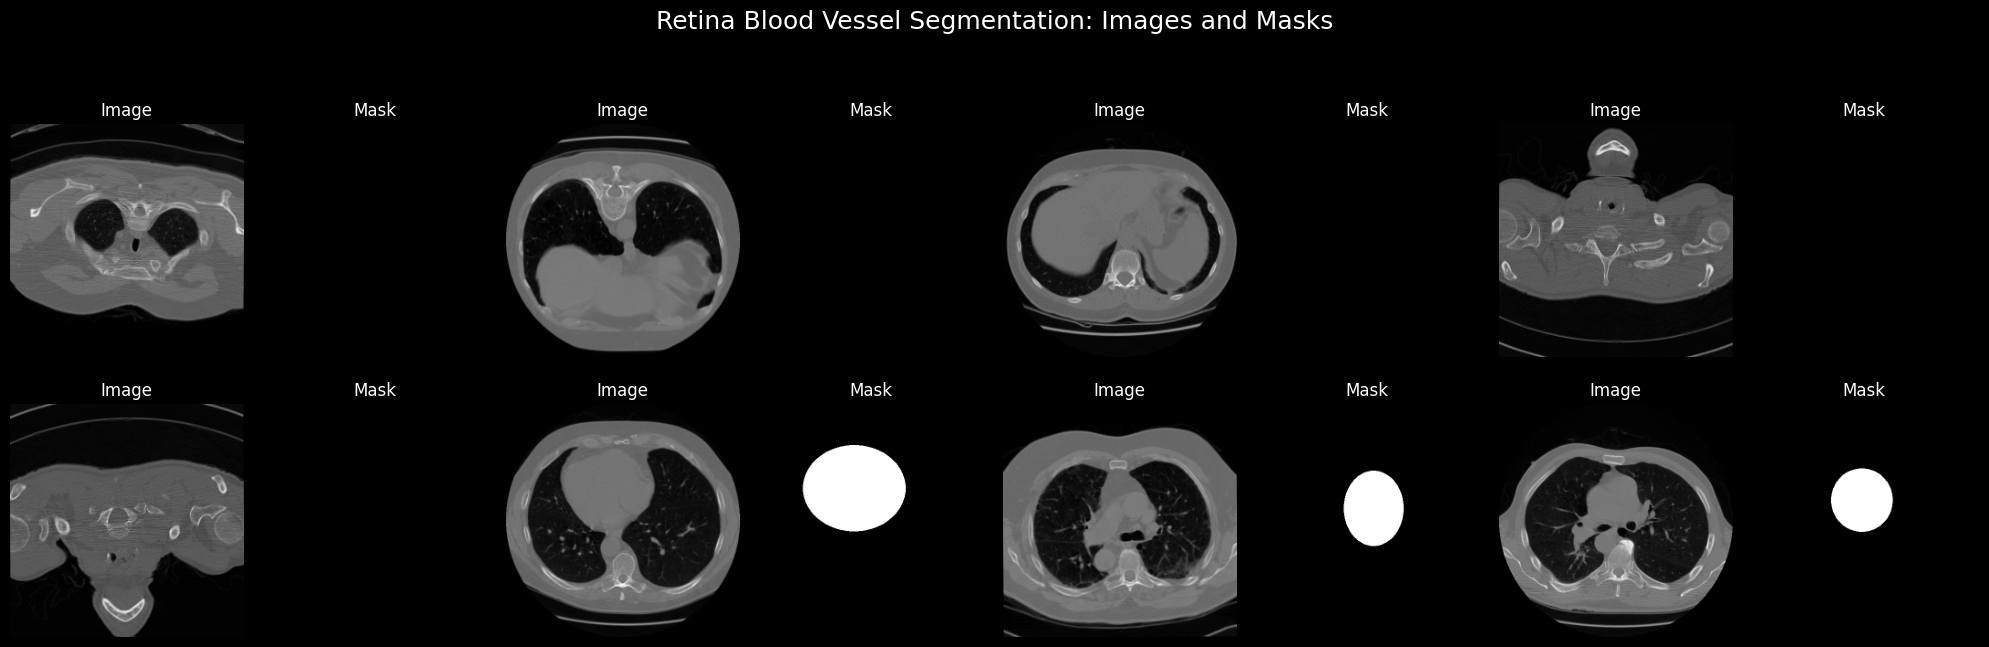

In [8]:
show_images_and_masks(images, masks, num_samples=8)

**<a id="5"></a>
<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #5642C5; box-shadow: 10px 10px 10px #042b4c">Modeling</p></b></h1>
<a class="btn" href="#home">Tabel of Contents</a>

### Encoder
   
The encoder is responsible for extracting features from the input image. It applies two convolutional layers followed by a ReLU Activation to learn patterns and then uses max pooling to reduce the image size help the model focus on important features.

In [9]:
def encoder_block(inputs, num_filters):

    x = Conv2D(num_filters, 3, padding='same')(inputs)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = Activation('relu')(x)

    x = MaxPool2D(pool_size=(2, 2))(x)
    
    return x

### Decoder

The decoder helps restore the original image size while combining the low-level and high-level features. It starts by upsampling the feature map, resizes the corresponding encoder output (skip connection), merges them and then applies two convolution layers with ReLU.

In [10]:
def decoder_block(inputs, skip_features, num_filters):

    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)

    skip_features = Resizing(x.shape[1], x.shape[2])(skip_features)

    x = Concatenate()([x, skip_features])

    x = Conv2D(num_filters, 3, padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = Activation('relu')(x)

    return x

### Defining the U-Net Model

This function builds the complete U-Net architecture. It connects multiple encoder and decoder blocks and includes a bottleneck in the middle. The final output layer uses a sigmoid activation for segmentation.

In [11]:
def unet_model(input_shape=(256, 256, 3), num_classes=1):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Contracting Path (Encoder)
    s1 = encoder_block(inputs, 64)
    s2 = encoder_block(s1, 128)
    s3 = encoder_block(s2, 256)
    s4 = encoder_block(s3, 512)
    
    # Bottleneck
    b1 = Conv2D(1024, 3, padding='same')(s4)
    b1 = Activation('relu')(b1)
    b1 = Conv2D(1024, 3, padding='same')(b1)
    b1 = Activation('relu')(b1)
    
    # Expansive Path (Decoder)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    outputs = Conv2D(num_classes, 1, padding='same', activation='sigmoid')(d4)
    
    model = Model(inputs=inputs, outputs=outputs, name='U-Net')
    return model


In [12]:
model = unet_model(input_shape=(image_size, image_size, 3), num_classes=1)
model.summary()

I0000 00:00:1751652811.957982      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 128)  │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 64, 64, 256)    │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_5 (Activation) │ (None, 64, 64, 256)    │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ activation_5[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_6 (Activation) │ (None, 32, 32, 512)    │              0 │ conv2d_6[0][0]         │
├──────────────────────

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Compile model
model.compile(
    optimizer='adam',
    loss= sm.losses.bce_dice_loss,
    metrics=['accuracy', sm.metrics.iou_score]
)

# Callbacks
checkpoint_cb = ModelCheckpoint(
    'best_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

early_stopping_cb = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    restore_best_weights=True,
    verbose=1
)

# Train model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/20


I0000 00:00:1751652824.630717      69 service.cc:148] XLA service 0x7aa370009b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751652824.631403      69 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751652825.709214      69 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-04 18:13:52.099974: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=2} for conv (f32[32,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-07-04

23/58 ━━━━━━━━━━━━━━━━━━━━ 28s 825ms/step - accuracy: 0.8358 - iou_score: 0.0197 - loss: 1.3431

E0000 00:00:1751652909.091222      67 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751652909.325235      67 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751652909.885504      67 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751652910.143755      67 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9030 - iou_score: 0.0286 - loss: 1.2157

E0000 00:00:1751652981.504334      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751652981.760571      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_loss improved from inf to 0.97615, saving model to best_model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.9038 - iou_score: 0.0289 - loss: 1.2136 - val_accuracy: 0.9708 - val_iou_score: 0.0885 - val_loss: 0.9762
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.9653 - iou_score: 0.1509 - loss: 0.8707
Epoch 2: val_loss improved from 0.97615 to 0.58043, saving model to best_model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 53s 910ms/step - accuracy: 0.9653 - iou_score: 0.1523 - loss: 0.8688 - val_accuracy: 0.9687 - val_iou_score: 0.3725 - val_loss: 0.5804
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.9483 - iou_score: 0.2764 - loss: 0.8521
Epoch 3: val_loss improved from 0.58043 to 0.31826, saving model to best_model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 53s 906ms/step - accuracy: 0.9485 - iou_score: 0.2780 - loss: 0.8492 - val_accuracy: 0.9853 - val_iou_score: 0.5781 - val_loss: 0.3183
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step 

In [14]:
pd.DataFrame(history.history)

,accuracy,iou_score,loss,val_accuracy,val_iou_score,val_loss
0,0.954488,0.045640,1.088326,0.970783,0.088543,0.976154
1,0.966916,0.233579,0.760862,0.968741,0.372475,0.580428
2,0.961930,0.370492,0.680246,0.985274,0.578098,0.318260
3,0.987728,0.661855,0.262644,0.986939,0.629464,0.300277
4,0.985953,0.621342,0.302199,0.989123,0.634178,0.245408
5,0.990187,0.724344,0.203247,0.989480,0.629011,0.256853
6,0.990942,0.743354,0.186050,0.990732,0.697449,0.194506
7,0.989608,0.713832,0.210539,0.990295,0.660737,0.227346
8,0.990032,0.720310,0.206746,0.991808,0.719674,0.173415
9,0.992130,0.772511,0.161113,0.992278,0.730481,0.161591


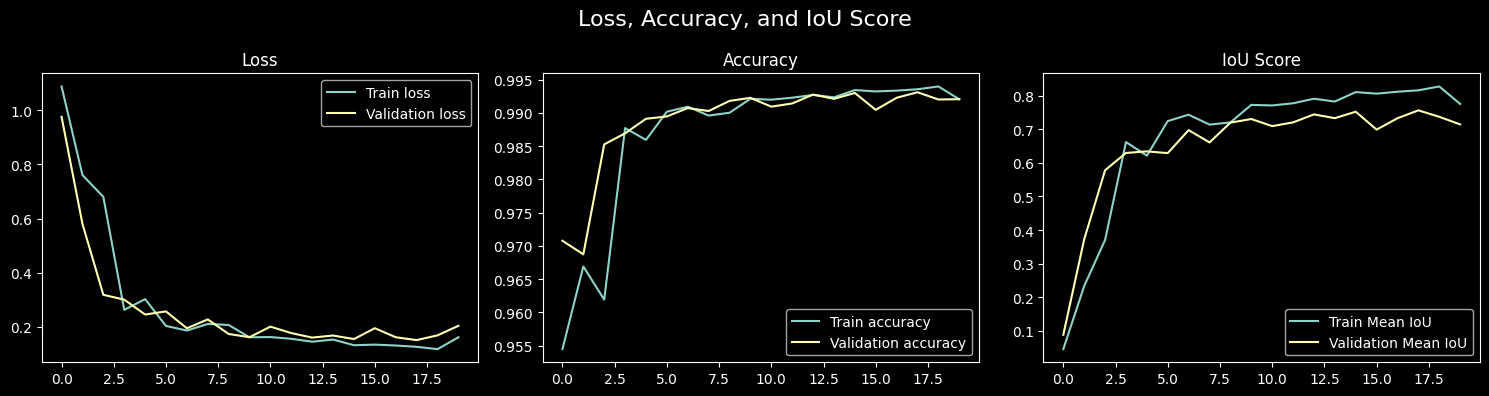

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

# Plot Loss
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].set_title("Loss")
ax[0].legend()

# Plot Accuracy
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].set_title("Accuracy")
ax[1].legend()

# Plot Mean IoU
ax[2].plot(history.epoch, history.history["iou_score"], label="Train Mean IoU")
ax[2].plot(history.epoch, history.history["val_iou_score"], label="Validation Mean IoU")
ax[2].set_title("IoU Score")
ax[2].legend()

fig.suptitle('Loss, Accuracy, and IoU Score', fontsize=16)
plt.tight_layout()
plt.show()

**<a id="6"></a>
<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #5642C5; box-shadow: 10px 10px 10px #042b4c">Evaluation</p></b></h1>
<a class="btn" href="#home">Tabel of Contents</a>

In [16]:
model = tf.keras.models.load_model(
    "/kaggle/working/best_model.keras",
    compile=False 
)
model.compile(
    optimizer='adam',
    loss=sm.losses.bce_dice_loss,
    metrics=['accuracy', sm.metrics.iou_score]
)

In [17]:
results = model.evaluate(test_gen, verbose=-1)
for name, value in zip(["Test Loss","Test Accuracy","Test IOU Score"], results):
    print(f"{name}: {value:.4f}")

E0000 00:00:1751653993.891555      69 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751653994.132584      69 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751653995.518266      69 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751653995.784315      69 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


Test Loss: 0.1244
Test Accuracy: 0.9937
Test IOU Score: 0.8215


In [18]:
# Predict masks for the test set using the model
preds = model.predict(test_gen, verbose=1)
# Apply threshold for binary masks
preds_bin = (preds > 0.5).astype(np.float32)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 414ms/step


In [19]:
def display_predictions(test_gen, preds_bin, n_samples = 4):
    """
    Display original image, ground truth mask, and predicted mask.
    """
    images, true_masks = test_gen[0]
    pred_masks = preds_bin[:len(images)] 
    fig, axes = plt.subplots(n_samples, 3, figsize=(12, 3 * n_samples))
    
    for i in range(n_samples):
        img = images[i]
        true_mask = true_masks[i]
        pred_mask = pred_masks[i]
    
        if true_mask.shape[-1] == 1:
            true_mask = np.squeeze(true_mask)
        if pred_mask.shape[-1] == 1:
            pred_mask = np.squeeze(pred_mask)
    
        # Image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Image {i+1}")
        axes[i, 0].axis("off")
    
        # Ground Truth Mask
        axes[i, 1].imshow(true_mask, cmap='gray')
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis("off")
    
        # Predicted Mask
        axes[i, 2].imshow(pred_mask, cmap='gray')
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")
    
    plt.tight_layout()
    plt.show()


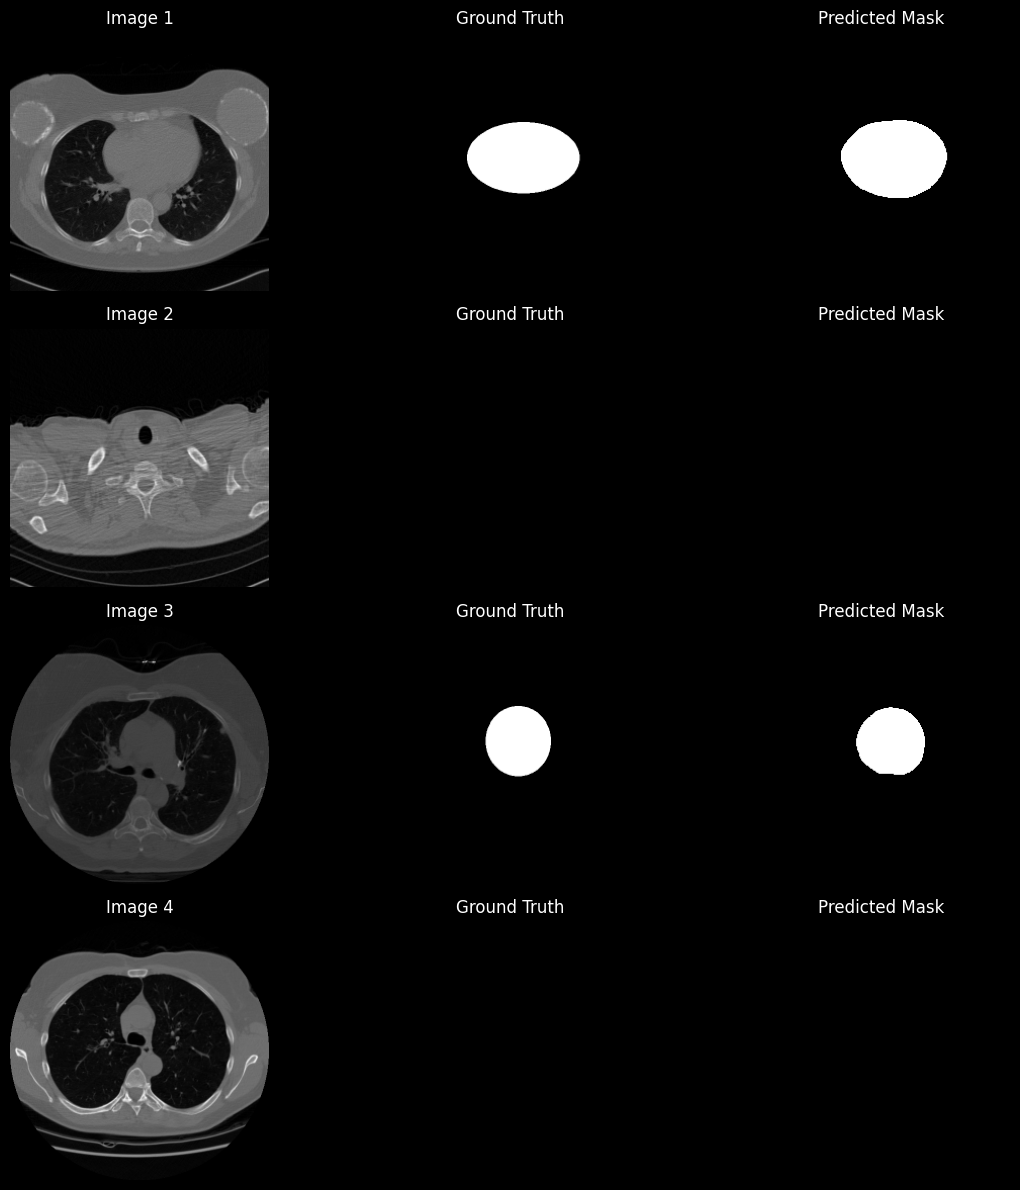

In [20]:
display_predictions(test_gen, preds_bin, n_samples = 4)

**<a id="7"></a>
<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #5642C5; box-shadow: 10px 10px 10px #042b4c">Pretrained UNet</p></b></h1>
<a class="btn" href="#home">Tabel of Contents</a>

In [21]:
BACKBONE = "efficientnetb7"
model = sm.Unet(
    backbone_name=BACKBONE,
    input_shape=(image_size, image_size, 3),
    encoder_weights='imagenet',
    classes=1,
    activation='sigmoid'
)
model.summary()

258434480/258434480 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 64)   │          1,728 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 64)   │            256 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 64)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 64)   │            576 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 64)   │            256 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 64)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 64)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 64)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 16)       │          1,040 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 64)       │          1,088 │ block1a_se_reduce[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_excite         │ (None, 128, 128, 64)   │              0 │ block1a_activation[0]… │
│ (Multiply)                │                        │                │ block1a_se_expand[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 128, 128, 32)   │          2,048 │ block1a_se_excite[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn   

 Total params: 75,048,097 (286.29 MB)

 Trainable params: 74,735,393 (285.09 MB)

 Non-trainable params: 312,704 (1.19 MB)

In [22]:
# Compile
model.compile(
    optimizer='adam',
    loss=sm.losses.bce_dice_loss,
    metrics=['accuracy', sm.metrics.iou_score]
)

# Callbacks
checkpoint_cb = ModelCheckpoint(
    'best_model_pred.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

early_stopping_cb = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    restore_best_weights=True,
    verbose=1
)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/20


E0000 00:00:1751654260.808718      67 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751654261.045324      67 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751654261.843612      67 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751654262.049524      67 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751654262.692961      67 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

42/58 ━━━━━━━━━━━━━━━━━━━━ 15s 983ms/step - accuracy: 0.9360 - iou_score: 0.1414 - loss: 1.0296

E0000 00:00:1751654422.798131      68 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751654422.992488      68 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751654423.526049      68 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751654423.726637      68 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751654424.104287      68 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9466 - iou_score: 0.1842 - loss: 0.9392
Epoch 1: val_loss improved from inf to 6.51061, saving model to best_model_pred.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 525s 4s/step - accuracy: 0.9471 - iou_score: 0.1867 - loss: 0.9343 - val_accuracy: 0.2343 - val_iou_score: 0.0370 - val_loss: 6.5106
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 0.9916 - iou_score: 0.6746 - loss: 0.2290
Epoch 2: val_loss improved from 6.51061 to 6.15699, saving model to best_model_pred.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9916 - iou_score: 0.6749 - loss: 0.2287 - val_accuracy: 0.3877 - val_iou_score: 0.0461 - val_loss: 6.1570
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 973ms/step - accuracy: 0.9929 - iou_score: 0.7615 - loss: 0.1621
Epoch 3: val_loss improved from 6.15699 to 1.21632, saving model to best_model_pred.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9929 - iou_score: 0.7616 - loss: 0.1621 - val_accuracy: 0.

In [23]:
pd.DataFrame(history.history)

,accuracy,iou_score,loss,val_accuracy,val_iou_score,val_loss
0,0.976286,0.333117,0.649955,0.234272,0.037025,6.510610
1,0.991509,0.696750,0.212298,0.387707,0.046097,6.156987
2,0.992848,0.767692,0.157154,0.845646,0.158456,1.216320
3,0.993758,0.804220,0.130933,0.989004,0.679768,0.240598
4,0.992446,0.773231,0.159281,0.938655,0.310782,0.786904
5,0.993668,0.810152,0.130025,0.981972,0.577916,0.361366
6,0.993545,0.807237,0.129812,0.982520,0.563938,0.348526
7,0.994483,0.835116,0.110995,0.991821,0.773291,0.177537
8,0.994556,0.840724,0.106807,0.992930,0.791892,0.155892
9,0.995059,0.854348,0.096336,0.994176,0.821913,0.126449


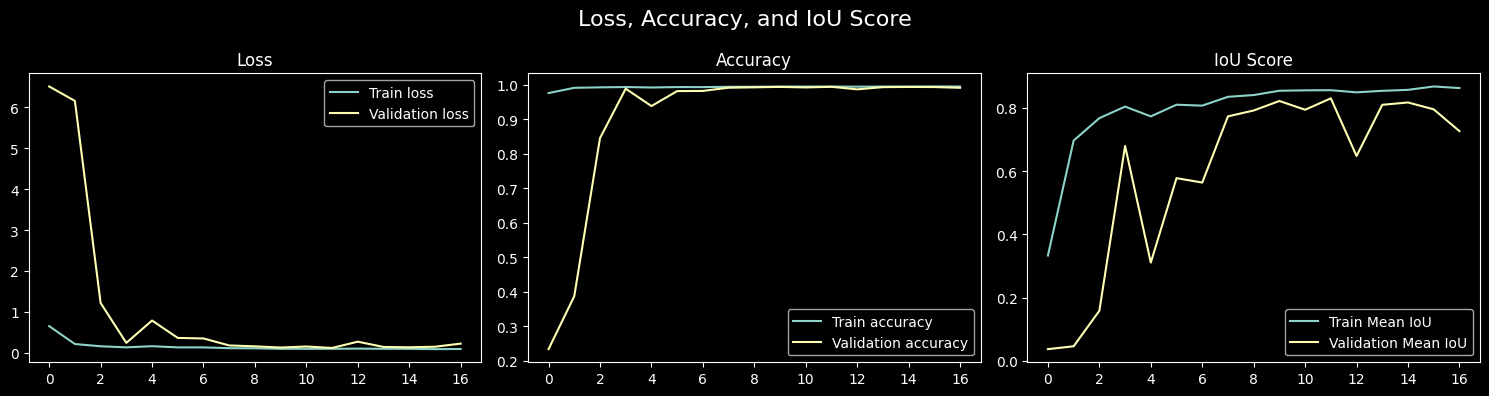

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

# Plot Loss
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].set_title("Loss")
ax[0].legend()

# Plot Accuracy
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].set_title("Accuracy")
ax[1].legend()

# Plot Mean IoU
ax[2].plot(history.epoch, history.history["iou_score"], label="Train Mean IoU")
ax[2].plot(history.epoch, history.history["val_iou_score"], label="Validation Mean IoU")
ax[2].set_title("IoU Score")
ax[2].legend()

fig.suptitle('Loss, Accuracy, and IoU Score', fontsize=16)
plt.tight_layout()
plt.show()

**<a id="8"></a>
<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #5642C5; box-shadow: 10px 10px 10px #042b4c">Evaluation</p></b></h1>
<a class="btn" href="#home">Tabel of Contents</a>

In [25]:
model = tf.keras.models.load_model(
    "/kaggle/working/best_model_pred.keras",
    compile=False 
)
model.compile(
    optimizer='adam',
    loss=sm.losses.bce_dice_loss,
    metrics=['accuracy', sm.metrics.iou_score]
)

In [26]:
results = model.evaluate(test_gen, verbose=-1)
for name, value in zip(["Test Loss","Test Accuracy","Test IOU Score"], results):
    print(f"{name}: {value:.4f}")

E0000 00:00:1751655602.711357      68 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751655602.950368      68 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


Test Loss: 0.1049
Test Accuracy: 0.9945
Test IOU Score: 0.8457


In [27]:
# Predict masks for the test set using the model
preds = model.predict(test_gen, verbose=1)
# Apply threshold for binary masks
preds_bin = (preds > 0.5).astype(np.float32)

12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step


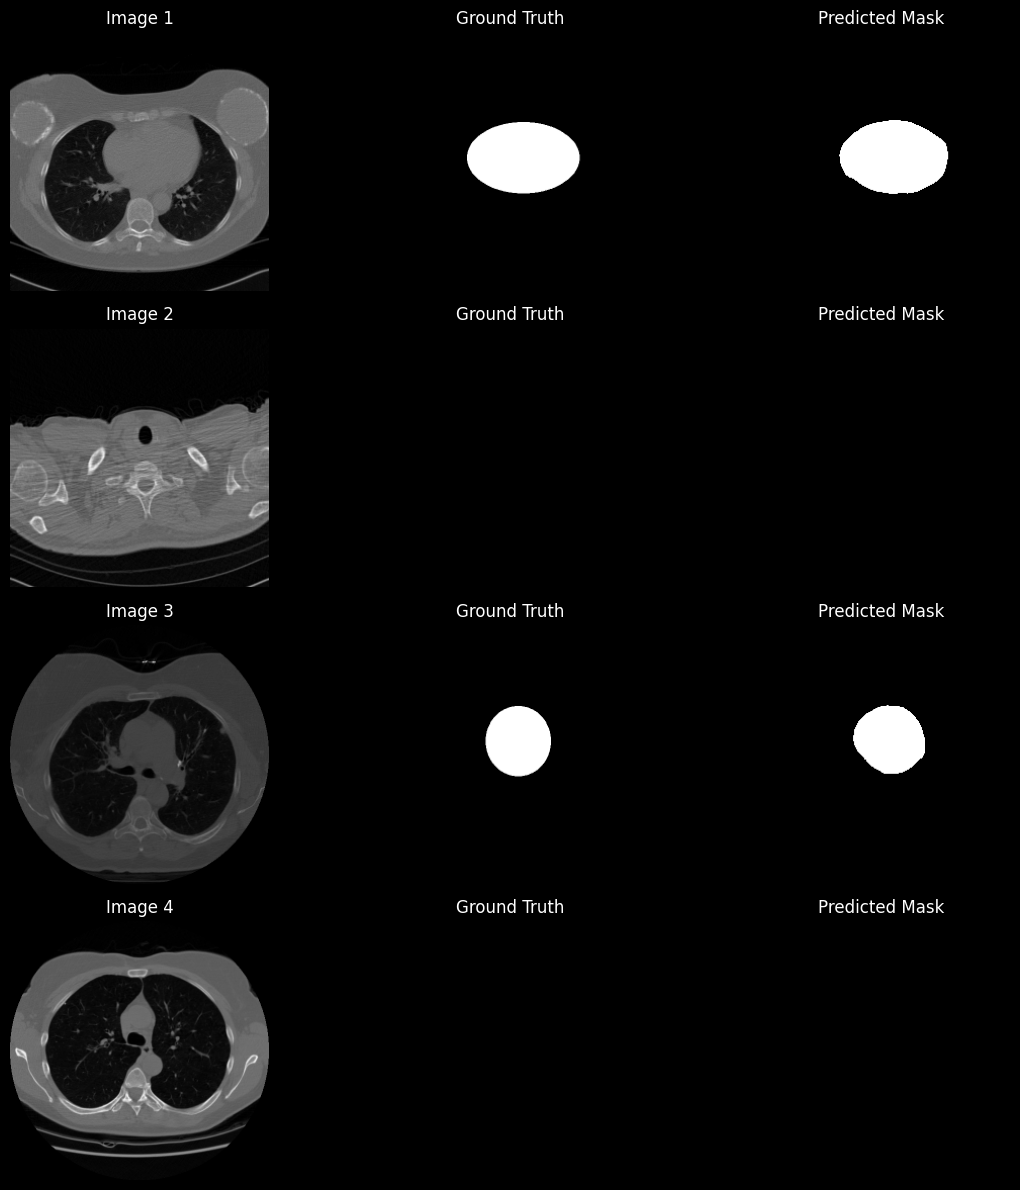

In [28]:
display_predictions(test_gen, preds_bin, n_samples = 4)